# Load

## Libraries

In [22]:
%matplotlib notebook

In [5]:
import numpy as np
import sklearn as skl
from sklearn import datasets

In [34]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Utilities

In [56]:
def labelXYZ(ax, xlabel, ylabel, zlabel=None, params={}):
    ax.set_xlabel(xlabel, **params)
    ax.set_ylabel(ylabel, **params)
    if zlabel:
        ax.set_zlabel(zlabel, **params)
    return ax

## Data

In [95]:
iris = skl.datasets.load_iris()
X = iris.data # 150 samples by (petal length, petal width, sepal length, sepal width)
n,d = X.shape
Y = iris.target # 3 possible species

In [74]:
faces = skl.datasets.fetch_olivetti_faces()
X = faces.data
n,d = X.shape # d = 64x64
Y = faces.target

# Analysis

## Inspect SVD

In [96]:
U,S,Vt = np.linalg.svd(X - np.mean(X, axis=0))

<IPython.core.display.Javascript object>


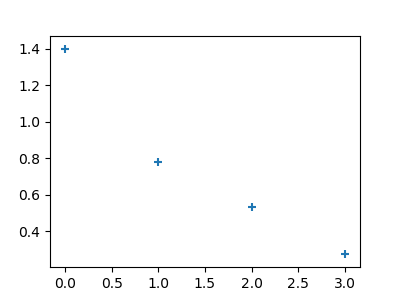

In [98]:
fig,ax = plt.subplots(1, figsize=[4,3])
ax.scatter(list(range(len(S))), np.log10(S), marker='+')

<IPython.core.display.Javascript object>


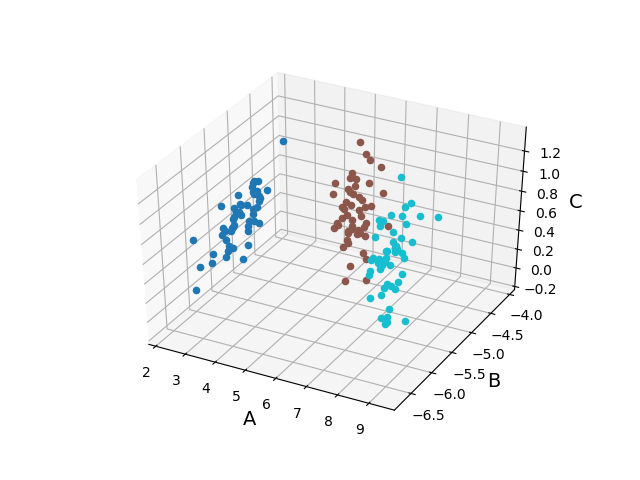

In [99]:
fig= plt.figure()
ax = fig.add_subplot(111, projection='3d')
pcX = X@Vt.T[:,:3]
colors, cnorm = [mpl.cm.get_cmap('tab10'), np.max(Y)]
for i,j,k,c in zip(pcX[:,0], pcX[:,1], pcX[:,2],Y):
    ax.scatter(i,j,k,color=colors(c/cnorm))
labelXYZ(ax, 'A','B','C', {'fontsize': 14});

## Agglomerative clustering using minimax